# Naives Bayes
### Data Mining Classification Project
by Rick Gosalvez, SV@Home, SJSU MSDA (rick@siliconvalleyathome.org) 

#### Are CA AFH State Tools Speeding Up Approvals? What is the Optimal Mix?

<li>Data from affordable and market rate developers and opensource.
<li>Use 3 methods to classify data.
<li>21 features

#### Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import scikitplot as skplt

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder

from sklearn.model_selection import train_test_split

from sklearn.naive_bayes import GaussianNB              # Continuous set
from sklearn.naive_bayes import MultinomialNB           # Finite set (e.g. descrete)
from sklearn.naive_bayes import BernoulliNB             # Binary set

from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, make_scorer
from sklearn.metrics import roc_curve

#### Load data and preview

In [2]:
df = pd.read_csv('DATA_ML_Project_MFR_FINAL.csv', parse_dates=['Submitted','Approved'])
df.head()

,Dev,Name,Address,City,GP_COMPLY,Z_COMPLY,TOD,PLAN_AREA,DU,MKT,AFH,SB35,SB330,AB1763,AB2162,AB2345,AB2372,AB3194,Submitted,Approved
0,RCD,Madrone Terrace,60060 E 14th Street,Ashland,Y,Y,Y,N,79,1,79,Y,NaN,NaN,NaN,NaN,NaN,NaN,2019-08-12,2019-11-13
1,NaN,Fourth Street,1900 Fourth Street,Berkeley,Y,Y,Y,Y,260,130,130,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2018-03-08,2021-04-22
2,RCD,Maudelle Miller Shirek,2001 Ashby,Berkeley,Y,Y,Y,Y,87,1,86,Y,NaN,NaN,NaN,NaN,NaN,NaN,2019-10-04,2019-12-20
3,NaN,Blake,2015 Blake,Berkeley,Y,Y,Y,Y,155,155,0,NaN,Y,NaN,NaN,NaN,NaN,NaN,2020-07-10,2021-03-18
4,NaN,Telegraph,3031 Telegraph,Berkeley,Y,N,N,N,110,110,0,NaN,Y,NaN,NaN,NaN,NaN,NaN,2020-08-05,2020-11-20


#### Manual review and assessment

As collected the dataset appears to favor binary classification because most fields are, or are not true. Each input feature is mutually conditionally independent. 
* <b>Gaussian</b> - I do not see, nor can I assume a normal/continous distribution of days or dwelling units as the dataset is limited and does not follow a normal distribution. Each project is unique and includes several variables that feed into a usable dataset. Perhaps <u>regression</u> would be a good approach for predicting the number of days with a large authoritative dataset; however, as the number of variables that affect approval time (many of which have no data available) is large, improving certainty by converting days into binary form by applying a cut-off is recommended for this model for this dataset. 
* <b>Multinomial</b> - No count or frequency of values except for units or days exist. Since the goal is to determine if state tools affect project approval times, this model was not selected for assessment. <u>Clustering, then classifying</u> is not the recommended approach.
* <b>Binomial</b> - The majority of data is binary, therefore a <u>binary table is recommended for this model</u>. Numeric datasets are easily converted to binary by applying cut-offs. For units, what matters is if the project is considered 100% affordable, part affordable, or market, therefore if the number of DU = AFH (+_ 2 unit), then it is 100% affordable. If a project has greater than 15% affordable, then I can assume they meet typical inclusionary requirments and are part affordable, if it meets neither, it is a market project. Regarding streamlining, State laws require qualified projects are approved either 90 or 180 days based on the situation; therefore, we can assume that projects that used state tools and were approved within 180 days of application were 'streamlined.'

#### Model Selection: <b>Binomial</b> analysis is recommended for this model.

#### Clean and prepare data

In [3]:
# drop names

df.drop(columns=['Dev', 'Name','Address'], inplace=True)
df.head()

,City,GP_COMPLY,Z_COMPLY,TOD,PLAN_AREA,DU,MKT,AFH,SB35,SB330,AB1763,AB2162,AB2345,AB2372,AB3194,Submitted,Approved
0,Ashland,Y,Y,Y,N,79,1,79,Y,NaN,NaN,NaN,NaN,NaN,NaN,2019-08-12,2019-11-13
1,Berkeley,Y,Y,Y,Y,260,130,130,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2018-03-08,2021-04-22
2,Berkeley,Y,Y,Y,Y,87,1,86,Y,NaN,NaN,NaN,NaN,NaN,NaN,2019-10-04,2019-12-20
3,Berkeley,Y,Y,Y,Y,155,155,0,NaN,Y,NaN,NaN,NaN,NaN,NaN,2020-07-10,2021-03-18
4,Berkeley,Y,N,N,N,110,110,0,NaN,Y,NaN,NaN,NaN,NaN,NaN,2020-08-05,2020-11-20


In [4]:
# Part_AFH (> 15% inclusionary AFH), All_AFH (Y/N)
df['All_AFH']  = df.AFH >= df.DU - 2
df['Part_AFH'] = df.AFH/df.DU >= 0.15
df

,City,GP_COMPLY,Z_COMPLY,TOD,PLAN_AREA,DU,MKT,AFH,SB35,SB330,AB1763,AB2162,AB2345,AB2372,AB3194,Submitted,Approved,All_AFH,Part_AFH
0,Ashland,Y,Y,Y,N,79,1,79,Y,NaN,NaN,NaN,NaN,NaN,NaN,2019-08-12,2019-11-13,True,True
1,Berkeley,Y,Y,Y,Y,260,130,130,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2018-03-08,2021-04-22,False,True
2,Berkeley,Y,Y,Y,Y,87,1,86,Y,NaN,NaN,NaN,NaN,NaN,NaN,2019-10-04,2019-12-20,True,True
3,Berkeley,Y,Y,Y,Y,155,155,0,NaN,Y,NaN,NaN,NaN,NaN,NaN,2020-07-10,2021-03-18,False,False
4,Berkeley,Y,N,N,N,110,110,0,NaN,Y,NaN,NaN,NaN,NaN,NaN,2020-08-05,2020-11-20,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
107,Sunnyvale,Y,N,N,N,141,123,18,NaN,Y,NaN,NaN,NaN,NaN,NaN,2020-08-28,2021-02-26,False,False
108,Sunnyvale,Y,Y,Y,Y,28,24,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2021-02-17,NaT,False,False
109,Sunnyvale,Y,Y,Y,Y,35,30,5,NaN,Y,NaN,NaN,NaN,NaN,NaN,2021-03-05,NaT,False,False
110,Vallejo,Y,Y,N,N,75,1,74,Y,NaN,NaN,Y,NaN,NaN,NaN,2020-07-16,2020-10-29,True,True


In [5]:
# calculate days and cut-off, if < 180 days '1', else '0'
df['Days']         = df.Approved - df.Submitted
df['Streamlined']  = df['Days'].dt.days <= 180
df.head()

,City,GP_COMPLY,Z_COMPLY,TOD,PLAN_AREA,DU,MKT,AFH,SB35,SB330,...,AB2162,AB2345,AB2372,AB3194,Submitted,Approved,All_AFH,Part_AFH,Days,Streamlined
0,Ashland,Y,Y,Y,N,79,1,79,Y,NaN,...,NaN,NaN,NaN,NaN,2019-08-12,2019-11-13,True,True,93 days,True
1,Berkeley,Y,Y,Y,Y,260,130,130,NaN,NaN,...,NaN,NaN,NaN,NaN,2018-03-08,2021-04-22,False,True,1141 days,False
2,Berkeley,Y,Y,Y,Y,87,1,86,Y,NaN,...,NaN,NaN,NaN,NaN,2019-10-04,2019-12-20,True,True,77 days,True
3,Berkeley,Y,Y,Y,Y,155,155,0,NaN,Y,...,NaN,NaN,NaN,NaN,2020-07-10,2021-03-18,False,False,251 days,False
4,Berkeley,Y,N,N,N,110,110,0,NaN,Y,...,NaN,NaN,NaN,NaN,2020-08-05,2020-11-20,False,False,107 days,True


In [6]:
# drop unused columns
df.drop(columns=['DU', 'MKT','AFH','Submitted', 'Approved','Days'], inplace=True)
df.head()

,City,GP_COMPLY,Z_COMPLY,TOD,PLAN_AREA,SB35,SB330,AB1763,AB2162,AB2345,AB2372,AB3194,All_AFH,Part_AFH,Streamlined
0,Ashland,Y,Y,Y,N,Y,NaN,NaN,NaN,NaN,NaN,NaN,True,True,True
1,Berkeley,Y,Y,Y,Y,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,True,False
2,Berkeley,Y,Y,Y,Y,Y,NaN,NaN,NaN,NaN,NaN,NaN,True,True,True
3,Berkeley,Y,Y,Y,Y,NaN,Y,NaN,NaN,NaN,NaN,NaN,False,False,False
4,Berkeley,Y,N,N,N,NaN,Y,NaN,NaN,NaN,NaN,NaN,False,False,True


In [7]:
# filling in NaN with 0
df["SB35"].fillna(0, inplace = True)
df["SB330"].fillna(0, inplace = True)
df["AB1763"].fillna(0, inplace = True)
df["AB2162"].fillna(0, inplace = True)
df["AB2345"].fillna(0, inplace = True)
df["AB2372"].fillna(0, inplace = True)
df["AB3194"].fillna(0, inplace = True)
df.head()

,City,GP_COMPLY,Z_COMPLY,TOD,PLAN_AREA,SB35,SB330,AB1763,AB2162,AB2345,AB2372,AB3194,All_AFH,Part_AFH,Streamlined
0,Ashland,Y,Y,Y,N,Y,0,0,0,0,0.0,0,True,True,True
1,Berkeley,Y,Y,Y,Y,0,0,0,0,0,0.0,0,False,True,False
2,Berkeley,Y,Y,Y,Y,Y,0,0,0,0,0.0,0,True,True,True
3,Berkeley,Y,Y,Y,Y,0,Y,0,0,0,0.0,0,False,False,False
4,Berkeley,Y,N,N,N,0,Y,0,0,0,0.0,0,False,False,True


In [8]:
# converting 'AB2372' from float to int
df['AB2372'] = df['AB2372'].astype(int)
df.head()

,City,GP_COMPLY,Z_COMPLY,TOD,PLAN_AREA,SB35,SB330,AB1763,AB2162,AB2345,AB2372,AB3194,All_AFH,Part_AFH,Streamlined
0,Ashland,Y,Y,Y,N,Y,0,0,0,0,0,0,True,True,True
1,Berkeley,Y,Y,Y,Y,0,0,0,0,0,0,0,False,True,False
2,Berkeley,Y,Y,Y,Y,Y,0,0,0,0,0,0,True,True,True
3,Berkeley,Y,Y,Y,Y,0,Y,0,0,0,0,0,False,False,False
4,Berkeley,Y,N,N,N,0,Y,0,0,0,0,0,False,False,True


In [9]:
# converting 'Streamlined' boolean to int
df['All_AFH'] = df.apply(lambda row: row['All_AFH'] == True, axis=1).astype(int)
df['Part_AFH'] = df.apply(lambda row: row['Part_AFH'] == True, axis=1).astype(int)
df['Streamlined'] = df.apply(lambda row: row['Streamlined'] == True, axis=1).astype(int)
df.head()

,City,GP_COMPLY,Z_COMPLY,TOD,PLAN_AREA,SB35,SB330,AB1763,AB2162,AB2345,AB2372,AB3194,All_AFH,Part_AFH,Streamlined
0,Ashland,Y,Y,Y,N,Y,0,0,0,0,0,0,1,1,1
1,Berkeley,Y,Y,Y,Y,0,0,0,0,0,0,0,0,1,0
2,Berkeley,Y,Y,Y,Y,Y,0,0,0,0,0,0,1,1,1
3,Berkeley,Y,Y,Y,Y,0,Y,0,0,0,0,0,0,0,0
4,Berkeley,Y,N,N,N,0,Y,0,0,0,0,0,0,0,1


In [10]:
# convert Y and N to 1 and 0 (binary)
df = df.replace(['Y'],1)
df = df.replace(['N'],0)
df.head()

,City,GP_COMPLY,Z_COMPLY,TOD,PLAN_AREA,SB35,SB330,AB1763,AB2162,AB2345,AB2372,AB3194,All_AFH,Part_AFH,Streamlined
0,Ashland,1,1,1,0,1,0,0,0,0,0,0,1,1,1
1,Berkeley,1,1,1,1,0,0,0,0,0,0,0,0,1,0
2,Berkeley,1,1,1,1,1,0,0,0,0,0,0,1,1,1
3,Berkeley,1,1,1,1,0,1,0,0,0,0,0,0,0,0
4,Berkeley,1,0,0,0,0,1,0,0,0,0,0,0,0,1


### 2. Split input and output

In [11]:
# 13 input features (data attributes)
X=df.iloc[:,[1,2,3,4,5,6,7,8,9,10,11,12,13,0]]
X.keys()

Index(['GP_COMPLY', 'Z_COMPLY', 'TOD', 'PLAN_AREA', 'SB35', 'SB330', 'AB1763',
       'AB2162', 'AB2345', 'AB2372', 'AB3194', 'All_AFH', 'Part_AFH', 'City'],
      dtype='object')

In [12]:
# outcome/output
y=df['Streamlined']

In [13]:
X = round(X)
X.head()

,GP_COMPLY,Z_COMPLY,TOD,PLAN_AREA,SB35,SB330,AB1763,AB2162,AB2345,AB2372,AB3194,All_AFH,Part_AFH,City
0,1,1,1,0,1,0,0,0,0,0,0,1,1,Ashland
1,1,1,1,1,0,0,0,0,0,0,0,0,1,Berkeley
2,1,1,1,1,1,0,0,0,0,0,0,1,1,Berkeley
3,1,1,1,1,0,1,0,0,0,0,0,0,0,Berkeley
4,1,0,0,0,0,1,0,0,0,0,0,0,0,Berkeley


### 3. Make dummy features

In [14]:
X = pd.get_dummies(X, columns=['GP_COMPLY', 'Z_COMPLY', 'TOD', 'PLAN_AREA', 'SB35', 'SB330', 'AB1763',
       'AB2162', 'AB2345', 'AB2372', 'AB3194', 'All_AFH', 'Part_AFH', 'City',], drop_first=True)
X.head()

,GP_COMPLY_1,Z_COMPLY_1,TOD_1,PLAN_AREA_1,SB35_1,SB330_1,AB1763_1,AB2162_1,AB2345_1,AB3194_1,...,City_San Leandro,City_San jose,City_Santa Clara,City_Santa Clara,City_Santa Rosa,City_Saratoga,City_South Lake Tahoe,City_Sunnyvale,City_Vallejo,City_Walnut Creek
0,1,1,1,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,1,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,1,1,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,1,1,1,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### 4. Split into test and training

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1, stratify=y)

In [16]:
# Naives Bayes - Binary package
bnb = BernoulliNB (alpha=1.0, class_prior=[0.5, 0.5])
bnb.fit(X_train, y_train)

BernoulliNB(class_prior=[0.5, 0.5])

In [17]:
y_pred = bnb.predict(X_test)

In [18]:
confmat = pd.DataFrame(confusion_matrix(y_test, y_pred),
                      index=['True[0]','True[1]'],
                      columns=['Predict[0]','Predict[1]'])
confmat

,Predict[0],Predict[1]
True[0],16,2
True[1],2,3


In [19]:
# y_pred_p = bnb.predict_proba(X_test)

In [20]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.89      0.89      0.89        18
           1       0.60      0.60      0.60         5

    accuracy                           0.83        23
   macro avg       0.74      0.74      0.74        23
weighted avg       0.83      0.83      0.83        23



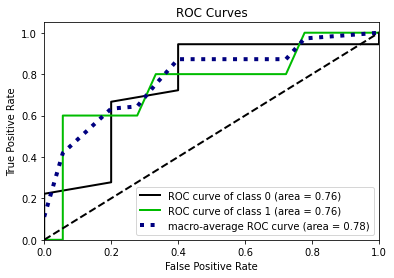

In [21]:
# ROC Graph
skplt.metrics.plot_roc(y_test, bnb.predict_proba(X_test),plot_micro=False)
plt.show()

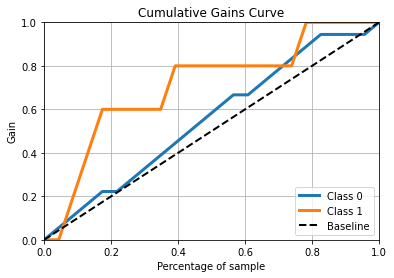

In [22]:
# Cumulative Gains
skplt.metrics.plot_cumulative_gain(y_test, bnb.predict_proba(X_test))
plt.show()

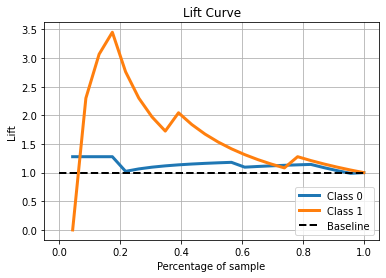

In [23]:
# Lift Chart
skplt.metrics.plot_lift_curve(y_test, bnb.predict_proba(X_test))
plt.show()

## Tune based on domain - change prior [0.1, 0.9] to [0.9, 0.1] with 0.1 increment

In [24]:
p1 = 0.1
p2 = 0.9

while p2 >= 0.1:
    bnb = BernoulliNB (alpha=1.0, class_prior=[p1, p2])
    bnb.fit(X_train, y_train)
    y_pred = bnb.predict(X_test)
    confmat = pd.DataFrame(confusion_matrix(y_test, y_pred),
                      index=['True[0]','True[1]'],
                      columns=['Predict[0]','Predict[1]'])
    print(f'Confusion Matrix: class_prior=[{p1:.1f}, {p2:.1f}]')
    print(confmat)
    print()
    y_pred_p = bnb.predict_proba(X_test)
    
    # Report
    print(f'Classification Report: class_prior=[{p1:.1f}, {p2:.1f}]')
    print(classification_report(y_test, y_pred))
    
    p1 += 0.1
    p2 -= 0.1
    print()

Confusion Matrix: class_prior=[0.1, 0.9]
         Predict[0]  Predict[1]
True[0]           8          10
True[1]           1           4

Classification Report: class_prior=[0.1, 0.9]
              precision    recall  f1-score   support

           0       0.89      0.44      0.59        18
           1       0.29      0.80      0.42         5

    accuracy                           0.52        23
   macro avg       0.59      0.62      0.51        23
weighted avg       0.76      0.52      0.56        23


Confusion Matrix: class_prior=[0.2, 0.8]
         Predict[0]  Predict[1]
True[0]          12           6
True[1]           1           4

Classification Report: class_prior=[0.2, 0.8]
              precision    recall  f1-score   support

           0       0.92      0.67      0.77        18
           1       0.40      0.80      0.53         5

    accuracy                           0.70        23
   macro avg       0.66      0.73      0.65        23
weighted avg       0.81      0.7

Assigning higher weight to prior (domain) affects model, after 80%.

For this model a class_prior of [0.7, 0.3] is most accurate at 87%. Class_prior should be weighed more heavily, on appropriate prior probabilities; however, should not exceed 80% as it decreases precision (positive prediction value) and increases false positives, which lowers accuracy. Domain knowledge matters for assessment of this dataset.

City should not affect approval times because state laws govern; however, in reality cities choose to fight the laws by sueing the state. All have lost so far, so I expect more data to become available in the coming year.

# Optimized

In [25]:
bnb = BernoulliNB (alpha=1.0, fit_prior=True, class_prior=[0.7, 0.3])
bnb.fit(X_train, y_train)

BernoulliNB(class_prior=[0.7, 0.3])

In [26]:
y_pred = bnb.predict(X_test)

In [27]:
confmat = pd.DataFrame(confusion_matrix(y_test, y_pred),
                      index=['True[0]','True[1]'],
                      columns=['Predict[0]','Predict[1]'])
confmat

,Predict[0],Predict[1]
True[0],17,1
True[1],2,3


In [28]:
# y_pred_p = bnb.predict_proba(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.89      0.94      0.92        18
           1       0.75      0.60      0.67         5

    accuracy                           0.87        23
   macro avg       0.82      0.77      0.79        23
weighted avg       0.86      0.87      0.86        23



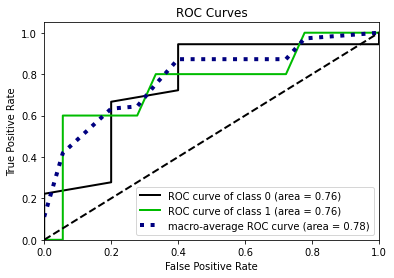

In [29]:
# ROC Graph
skplt.metrics.plot_roc(y_test, bnb.predict_proba(X_test),plot_micro=False)
plt.show()